In [1]:
import numpy as  np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
df=pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv')
df

,Date,Date_YMD,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,30 January 2020,2020-01-30,1,1,0,0,0,0
1,31 January 2020,2020-01-31,0,1,0,0,0,0
2,1 February 2020,2020-02-01,0,1,0,0,0,0
3,2 February 2020,2020-02-02,1,2,0,0,0,0
4,3 February 2020,2020-02-03,1,3,0,0,0,0
...,...,...,...,...,...,...,...,...
458,2 May 2021,2021-05-02,370090,19919645,300004,16281710,3423,218356
459,3 May 2021,2021-05-03,355769,20275414,318910,16600620,3439,221795
460,4 May 2021,2021-05-04,382847,20658261,337699,16938319,3786,225581
461,5 May 2021,2021-05-05,412624,21070885,330718,17269037,3979,229560


In [3]:
df1=df

In [4]:
def Recovery_Rate(RC,CC):
  return (RC/CC)*100

In [5]:
RR=[]
for i in df.index:
  RR.append(Recovery_Rate(df['Total Recovered'][i], df['Total Confirmed'][i]))

In [6]:
df1['Recovery Rate']=RR

In [7]:
def Case_Load_Rate(CC,RC,D):
  CaseLoad=CC-RC-D
  return (CaseLoad/CC)*100
  # return CaseLoad

In [8]:
CLR=[]
for i in df.index:
  CLR.append(Case_Load_Rate(df['Daily Confirmed'][i],df['Daily Recovered'][i],  df['Daily Deceased'][i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
df1['Case Load Rate']=CLR

In [10]:
def Delta(CLR,RR):
  return CLR-RR

In [11]:
Del=[]
for i in df.index:
  Del.append(Delta(df1['Case Load Rate'][i],df1['Recovery Rate'][i]))

In [12]:
df1['Delta']=Del

In [13]:
train_dates=pd.to_datetime(df['Date_YMD'])

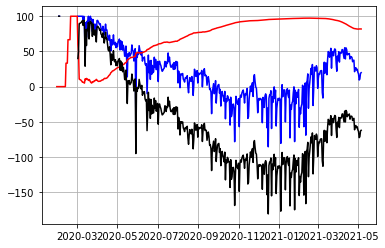

In [14]:
# plt.title("Red - Recovery Rate Blue - Case Load Rate Black-Delta")
plt.plot(train_dates,CLR,color="Blue", Label='Case Load Rate')
plt.plot(train_dates,RR,color="red", Label='Recovery Rate')
plt.plot(train_dates,Del,color="Black", Label='Delta')
plt.grid()

In [15]:
cols=list(df1)[9:10]
cols

['Case Load Rate']

In [16]:
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df1.dropna(inplace=True)

In [17]:
df_for_training=df1[cols].astype(float)

In [18]:
scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [19]:
trainX=[]
trainY=[]

In [20]:
n_future=1
n_past=14

In [21]:
for i in range(n_past, len(df_for_training_scaled)-n_future +1):
  trainX.append(df_for_training_scaled[i-n_past:i, 0:df_for_training.shape[1]])
  trainY.append(df_for_training_scaled[i+n_future-1:i+n_future,0])
trainX,trainY=np.array(trainX),np.array(trainY)

In [22]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error','mean_absolute_error'])

In [23]:
history=model.fit(trainX,trainY,epochs=90,batch_size=1,validation_split=0.2,verbose=1)

Epoch 1/90
336/336 [==============================] - 3s 6ms/step - loss: 0.4129 - mean_squared_error: 0.4129 - mean_absolute_error: 0.4379 - val_loss: 0.1698 - val_mean_squared_error: 0.1698 - val_mean_absolute_error: 0.3294
Epoch 2/90
336/336 [==============================] - 1s 4ms/step - loss: 0.1867 - mean_squared_error: 0.1867 - mean_absolute_error: 0.2946 - val_loss: 0.1362 - val_mean_squared_error: 0.1362 - val_mean_absolute_error: 0.2959
Epoch 3/90
336/336 [==============================] - 1s 4ms/step - loss: 0.1763 - mean_squared_error: 0.1763 - mean_absolute_error: 0.2789 - val_loss: 0.1206 - val_mean_squared_error: 0.1206 - val_mean_absolute_error: 0.2636
Epoch 4/90
336/336 [==============================] - 1s 4ms/step - loss: 0.2013 - mean_squared_error: 0.2013 - mean_absolute_error: 0.2915 - val_loss: 0.1762 - val_mean_squared_error: 0.1762 - val_mean_absolute_error: 0.3274
Epoch 5/90
336/336 [==============================] - 1s 4ms/step - loss: 0.1874 - mean_squared_

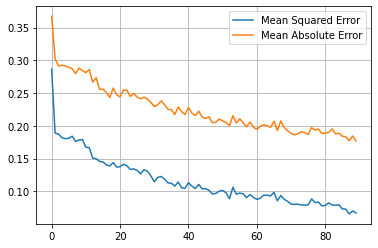

In [31]:
plt.plot(history.history['mean_squared_error'], Label='Mean Squared Error')
plt.plot(history.history['mean_absolute_error'], Label='Mean Absolute Error')
plt.grid()
plt.legend()

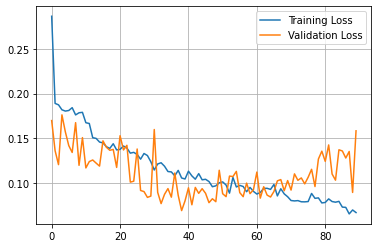

In [32]:
plt.plot(history.history['loss'], Label='Training Loss')
plt.plot(history.history['val_loss'], Label='Validation Loss')
plt.grid()
plt.legend()

In [26]:
n_f=60
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_f, freq='1d').tolist()
forecast = model.predict(trainX[-n_f:])
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]


forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [27]:
forecast_dates

[datetime.date(2021, 5, 6),
 datetime.date(2021, 5, 7),
 datetime.date(2021, 5, 8),
 datetime.date(2021, 5, 9),
 datetime.date(2021, 5, 10),
 datetime.date(2021, 5, 11),
 datetime.date(2021, 5, 12),
 datetime.date(2021, 5, 13),
 datetime.date(2021, 5, 14),
 datetime.date(2021, 5, 15),
 datetime.date(2021, 5, 16),
 datetime.date(2021, 5, 17),
 datetime.date(2021, 5, 18),
 datetime.date(2021, 5, 19),
 datetime.date(2021, 5, 20),
 datetime.date(2021, 5, 21),
 datetime.date(2021, 5, 22),
 datetime.date(2021, 5, 23),
 datetime.date(2021, 5, 24),
 datetime.date(2021, 5, 25),
 datetime.date(2021, 5, 26),
 datetime.date(2021, 5, 27),
 datetime.date(2021, 5, 28),
 datetime.date(2021, 5, 29),
 datetime.date(2021, 5, 30),
 datetime.date(2021, 5, 31),
 datetime.date(2021, 6, 1),
 datetime.date(2021, 6, 2),
 datetime.date(2021, 6, 3),
 datetime.date(2021, 6, 4),
 datetime.date(2021, 6, 5),
 datetime.date(2021, 6, 6),
 datetime.date(2021, 6, 7),
 datetime.date(2021, 6, 8),
 datetime.date(2021, 6, 9)

In [28]:
df_forecast = pd.DataFrame({'Date_YMD':np.array(forecast_dates), 'Case Load Rate':y_pred_future})
df_forecast['Date_YMD']=pd.to_datetime(df_forecast['Date_YMD'])

In [29]:
original=df1[['Date_YMD','Case Load Rate']]
original['Date_YMD']=pd.to_datetime(original['Date_YMD'])
original = original.loc[original['Date_YMD'] >= '2020-01-30']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


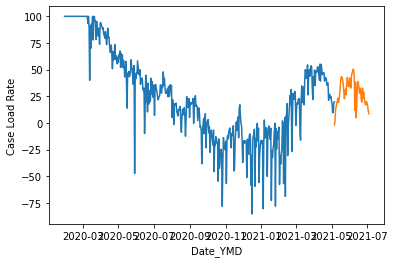

In [30]:
sns.lineplot(original['Date_YMD'], original['Case Load Rate'])
sns.lineplot(df_forecast['Date_YMD'], df_forecast['Case Load Rate'])